<a href="https://colab.research.google.com/github/Ovuowo-Rukevwe/Customer-Segmentation/blob/master/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 9.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.wh

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

In [64]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

batch_size=64;


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


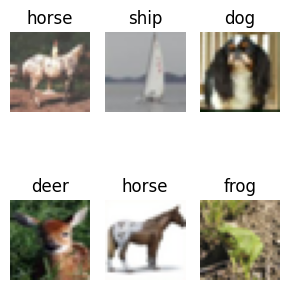

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure size
plt.figure(figsize=(3, 4))  # 6 columns and 4 rows

# Show images and print labels for the first 6 images
for i in range(batch_size):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [66]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) #This line applies the first convolutional layer (conv1) to the input x, then applies the ReLU activation function (torch.relu)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) #This line reshapes (flattens) the output tensor x from the previous layer to prepare it for the fully connected layers.
        x = torch.relu(self.fc1(x)) #This applies the ReLU activation function to the output of the first fully connected layer (fc1).
        x = self.fc2(x) #This applies the second fully connected layer (fc2) to produce the final output tensor x
        return x

## Check if GPU is available and set the device accordingly

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SimpleCNN().to(device)

## Define a Loss function and optimizer.
Using a Classification Cross-Entropy loss and Adam with momentum.

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
num_epochs = 5
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 1.3532, Train Accuracy: 0.5141, Val Accuracy: 0.6184
Epoch 2/5, Loss: 0.9858, Train Accuracy: 0.6513, Val Accuracy: 0.6645
Epoch 3/5, Loss: 0.8171, Train Accuracy: 0.7135, Val Accuracy: 0.6988
Epoch 4/5, Loss: 0.6955, Train Accuracy: 0.7583, Val Accuracy: 0.7042
Epoch 5/5, Loss: 0.5841, Train Accuracy: 0.7967, Val Accuracy: 0.7201


##Saving our trained model

In [70]:
torch.save(model.state_dict(), 'cifar10_model.pth')

##Test the network on the test data
We have trained the network for 5 epoch over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

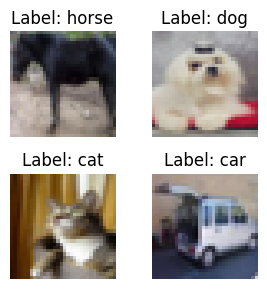

In [71]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
# Define the figure size
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

# Print images and labels for the first 4 images
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


In [72]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('cifar10_model.pth'))

<All keys matched successfully>

In [73]:
outputs = model(images)

In [74]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  horse dog   cat   truck


In [75]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


In [78]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.8 %
Accuracy for class: car   is 81.9 %
Accuracy for class: bird  is 63.5 %
Accuracy for class: cat   is 48.1 %
Accuracy for class: deer  is 71.4 %
Accuracy for class: dog   is 60.7 %
Accuracy for class: frog  is 81.5 %
Accuracy for class: horse is 78.9 %
Accuracy for class: ship  is 79.8 %
Accuracy for class: truck is 77.5 %


# FGSM Attack

In [187]:
# FGSM Attack
model = SimpleCNN()
model.load_state_dict(torch.load('cifar10_model.pth'))
model.eval()

# Choose randomly data from the test dataset
index = np.random.randint(0, len(test_dataset))
original_image, original_label = test_dataset[index]
print("Original Label:", original_label)


def generate_adversarial_example(model, image, label, epsilon=0.02):
    """
    Function to generate adversarial examples using Fast Gradient Sign Method (FGSM).

    Parameters:
    - model: Pre-trained neural network model
    - image: Original image tensor
    - label: True label of the original image
    - epsilon: Perturbation magnitude for FGSM

    Returns:
    - adversarial_image: Adversarial image tensor
    """
    image.requires_grad = True
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, torch.tensor([label]))

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * torch.sign(image.grad)
    adversarial_image = image + perturbation
    return adversarial_image.detach()

original_image = original_image.unsqueeze(0)
adversarial_image = generate_adversarial_example(model, original_image, original_label)

original_prediction = torch.argmax(model(original_image))
adversarial_prediction = torch.argmax(model(adversarial_image))

# Check if the predictions differ
if original_prediction != adversarial_prediction:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

    # Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction.item()])
print("Adversarial Prediction:", classes[adversarial_prediction.item()])

Original Label: 7
The image has not been attacked by an adversarial perturbation.
Original Prediction: cat
Adversarial Prediction: cat


In [184]:
# BIM Attack
attack = torchattacks.FGSM(model, eps=8/255)

# Load the model
model = SimpleCNN()
model.load_state_dict(torch.load('cifar10_model.pth'))
model.eval()

# Choose randomly data from the test dataset
index = np.random.randint(0, len(test_dataset))
original_image, original_label = test_dataset[index]
print("Original Label:", original_label)

# Ensure original_label is a PyTorch tensor
original_label_tensor = torch.tensor(original_label)

# Adversarial images using BIM attack
adv_images = attack(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
#print("Adversarial Images:", adv_images)

# Predictions on original and adversarial images
original_prediction = torch.argmax(model(original_image.unsqueeze(0)))
adversarial_prediction = torch.argmax(model(adv_images))

# Check if the predictions differ
if original_prediction != adversarial_prediction:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction.item()])
print("Adversarial Prediction:", classes[adversarial_prediction.item()])


Original Label: 8
The image has not been attacked by an adversarial perturbation.
Original Prediction: plane
Adversarial Prediction: plane


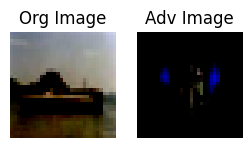

Original Prediction: plane
Adversarial Prediction: plane


In [185]:
# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adversarial_image.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction.item()])
print("Adversarial Prediction:", classes[adversarial_prediction.item()])
